In [61]:
import pandas as pd
import numpy as np
from  statsmodels.tsa.api import SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, ifft, fftfreq
import warnings
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)

In [2]:
class myHolt:
    def __init__(self, y, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.y0 = y[0]
        self.data = np.zeros(len(y))
        self.data[0] = self.y0
        self.l = np.zeros(len(y))
        self.l[0] = y[0]
        self.b = np.zeros(len(y))
        self.b[0] = 1 if y[1] > y[0] else -1
        
        for i in np.arange(1,len(y)):
            self.calcNextL(i, y[i-1])
            self.calcNextB(i)
            self.data[i] = self.l[i] + self.b[i]
            
    def calcNextL(self, t, val_real):
        l_before = self.l[t-1]
        b_before = self.b[t-1]
        self.l[t] = self.alpha * val_real + (1-self.alpha) * (l_before + b_before) 
          
    def calcNextB(self, t): 
        self.b[t] = self.beta * (self.l[t] - self.l[t-1]) + (1-self.beta)*self.b[t-1]

# IBM HOLT TEST

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-02-01,6.978967,7.087317,6.978967,7.068196,1.577106,674670
1962-02-02,7.068196,7.112811,7.036329,7.112811,1.587062,533460
1962-02-05,7.112811,7.112811,6.985341,7.023582,1.567152,329490
1962-02-06,7.023582,7.036329,6.998088,7.029955,1.568787,274575
1962-02-07,7.036329,7.074570,7.036329,7.036329,1.570211,266730
...,...,...,...,...,...,...
1965-12-06,8.070427,8.102294,7.934990,7.998725,1.791781,1041816
1965-12-07,8.026609,8.142129,8.026609,8.102294,1.814982,407940
1965-12-08,8.134162,8.205864,8.134162,8.150096,1.825689,395388


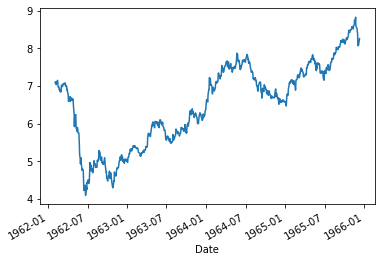

In [3]:
ibm = pd.read_csv('../Lab2/IBM.csv', index_col=['Date'])
ibm.index=pd.to_datetime(ibm.index, format='%d/%m/%Y')
freq = pd.infer_freq(ibm.index)
ibm['High'].plot()
#
ibm

1963-01-01 00:00:00


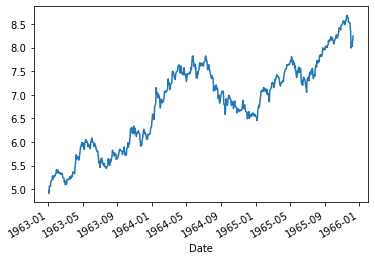

In [4]:
# take the linear part
timestart = datetime.datetime(1963,1,1)
timeend = datetime.datetime(1966,1,1)
print((timestart))
ibm_linear = ibm.loc['1963-01-02':'1966-01-01']
ibm_linear['Open'].plot()

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]

Holt's try to find manually    0.95
Holt's model estimated         1.00
My Holt's model estimation     0.95
Name: $\alpha$, dtype: float64 Holt's try to find manually    5.000000e-02
Holt's model estimated         1.175507e-13
My Holt's model estimation     5.900000e-01
Name: $\beta$, dtype: float64 [0.005080765714657853, 0.95, 0.5900000000000001]


,Holt's try to find manually,Holt's model estimated,My Holt's model estimation
$\alpha$,0.950000,1.000000e+00,0.950000
$\beta$,0.050000,1.175507e-13,0.590000
$\phi$,NaN,NaN,NaN
$l_0$,4.911196,4.968435e+00,4.971319
$b_0$,1.007098,1.000580e+00,-1.000000


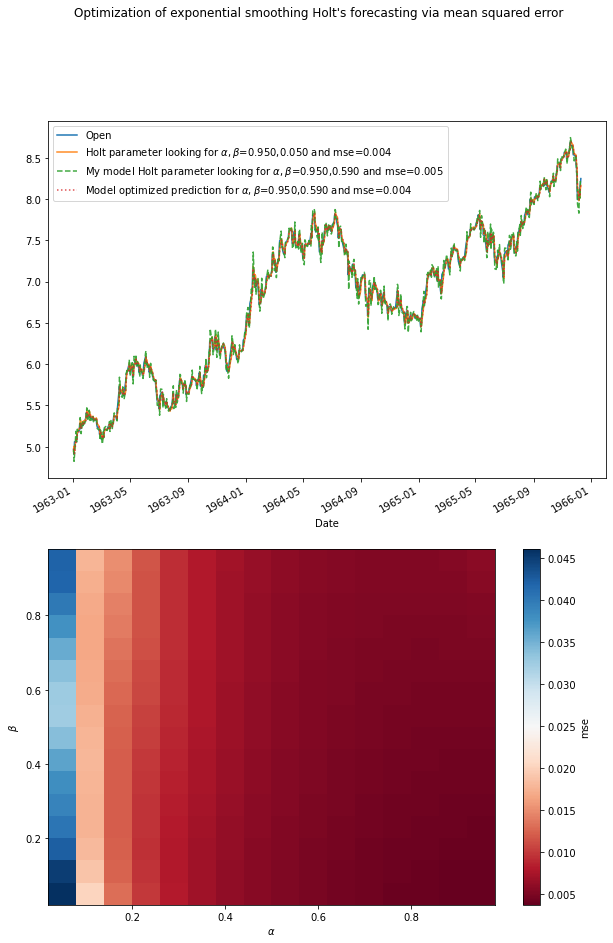

In [5]:
fig, ax = plt.subplots(2, figsize = (10,16))
plt.suptitle("Optimization of exponential smoothing Holt's forecasting via mean squared error")
col = 'Open'
numpy_df = ibm_linear[col].to_numpy()
#print(numpy_df)
best_mse = 1e18
best_mse_mine = [1e18, -1, -1]

bestFit = None
bestFitMine = None

# create grid for mse phase plot
start = 0.05
end = 1.0
step = 0.06
param_num =int((end - start)/step) + 1
alphas = np.arange(start, end, step)
betas = np.arange(start, end, step)
y, x = np.meshgrid(alphas, betas)

# take mse's
mses = []
mses_mine = []

l0 = None
b0 = None
# sweep through all alphas
for alpha in alphas:
    for beta in betas:
        # implemented one
        fit = Holt(numpy_df, exponential=True,
                   initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized = False)
        fitted = fit.fittedvalues
        
        # mine
        mHolt = myHolt(numpy_df, alpha, beta)
        l0 = mHolt.l[0]
        b0 = mHolt.b[0]
        fitMine = mHolt.data

        # calculate mse's
        mse = mean_squared_error(fitted, numpy_df)
        mseMine = mean_squared_error(fitMine, numpy_df)
        
        mses.append(mse)
        mses_mine.append(mseMine)
        #print(r"For $\alpha =$"+ f"{alpha:.3f}" "and $\beta =$"+ f"{beta:.3f} the mse is {mse:.3f}")    
        if mse < best_mse: 
            best_mse = mse
            bestFit = fit   
        if mseMine < best_mse_mine[0]: 
            best_mse_mine = [mseMine, alpha, beta]
            bestFitMine = fitMine       
        
# make optimized prediction from the library
fit = Holt(ibm_linear[col], exponential=True, initialization_method="estimated",).fit()  
m=mean_squared_error(np.array(fit.fittedvalues), numpy_df)


# plot the results 
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$"],
    columns=["Holt's try to find manually", "Holt's model estimated"],
)

results["Holt's try to find manually"] = [bestFit.params[p] for p in params] 
results["Holt's model estimated"] = [fit.params[p] for p in params] 
results["My Holt's model estimation"] = [best_mse_mine[1], best_mse_mine[2], np.nan, l0, b0]
alphas = results.iloc[0]
betas = results.iloc[1]
print(alphas, betas, best_mse_mine)
# plot 
#ax[0].plot(ibm_linear.index, numpy_df, label = 'original data')
ibm_linear[col].plot(ax=ax[0])
ax[0].plot(ibm_linear[col].index, bestFit.fittedvalues, '-', alpha=0.9,
           label = r'Holt parameter looking for $\alpha,\beta$=' + f'{alphas[0]:.3f},{betas[0]:.3f} and mse={best_mse:.3f}')
ax[0].plot(ibm_linear[col].index, fitMine, '--', alpha=0.9,
           label = r'My model Holt parameter looking for $\alpha,\beta$=' + f'{best_mse_mine[1]:.3f},{best_mse_mine[2]:.3f} and mse={best_mse_mine[0]:.3f}')
ax[0].plot(ibm_linear[col].index, fit.fittedvalues, ':', alpha=0.8, label = r'Model optimized prediction for $\alpha,\beta$=' + f'{alphas[-1]:.3f},{betas[-1]:.3f} and mse={m:.3f}')
ax[0].legend()

c = ax[1].pcolormesh(x, y, np.array(mses).reshape((param_num, param_num)), cmap='RdBu', vmin=np.min(mses), vmax=np.max(mses), shading='auto')
cbar = fig.colorbar(c, ax = ax[1])
cbar.ax.set_ylabel('mse')

#ax[1].plot(alphas, mses_stat, label = 'from statsmodel')
#ax[1].plot(alphas, mses_mine, label = 'from mymodel')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel(r"$\beta$")
#ax[1].set_zlabel(r"Holt mse")
#ax[1].set_title(r"Model parameter $\alpha$ optimization")
results

# Tripple exponential smoothing (Holt-Winter's method)

The forecasts generated by Holt’s linear method display a constant trend (increasing or decreasing) indefinitely into the future. Empirical evidence indicates that these methods tend to over-forecast, especially for longer forecast horizons. Motivated by this observation, Gardner & McKenzie (1985) introduced a parameter that “dampens” the trend to a flat line some time in the future. 

Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations

There are two variations to this method that differ in the nature of the seasonal component. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero

With the multiplicative method, the seasonal component is expressed in relative terms (percentages), and the series is seasonally adjusted by dividing through by the seasonal component. Within each year, the seasonal component will sum up to approximately m.

,price
2000-01-31,2330.7
2000-02-29,2050.6
2000-03-31,1783.3
2000-04-30,1632.9
2000-05-31,1513.1
...,...
2019-05-31,2115.2
2019-06-30,2407.5
2019-07-31,2437.2
2019-08-31,2215.6


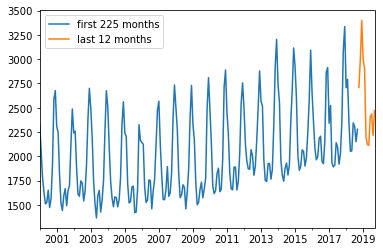

In [40]:
time = 12
usgas = pd.read_csv('USGas.csv')
datelist = pd.date_range('2000-01-01','2019-10-01', freq='M')
datelist
usgas.index = datelist
usgas.columns = ['price']
# take last time elements
usgas_last = usgas.tail(time)
usgas_last.columns = [f'last {time} months']
usgas_first = usgas.head(len(usgas) - time)
usgas_first.columns = [f'first {len(usgas)-time} months']

ax0=usgas_first.plot(label=f'first {len(usgas)-time} months')
usgas_last.plot(ax = ax0, label=f'last {time} months')
ax0.legend()
usgas

In [41]:
# simple smoothing
fit1 = SimpleExpSmoothing(usgas_first, initialization_method="estimated").fit()
# simple Holt's linear trend
fit2 = Holt(usgas_first, initialization_method="estimated").fit()
# Holt's exponential
fit3 = Holt(usgas_first, exponential=True, initialization_method="estimated").fit()
# Holt's damped
fit4 = Holt(usgas_first, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
# Holt's damped exponential
fit5 = Holt(
    usgas_first, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()


In [42]:

fit_add_add= ExponentialSmoothing(
    usgas_first,
    seasonal_periods=2,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit_add_mult= ExponentialSmoothing(
    usgas_first,
    seasonal_periods=2,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit_mult_add= ExponentialSmoothing(
    usgas_first,
    seasonal_periods=2,
    trend="mul",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit_mult_mult= ExponentialSmoothing(
    usgas_first,
    seasonal_periods=2,
    trend="mul",
    seasonal="mul",
    use_boxcox=True,
    damped_trend=True,
    initialization_method="estimated",
).fit()


params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]


C:\Users\maxgr\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [43]:

results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$",r"$\gamma$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's linear", "Holt's exponential", "Damped additive", "Damped multiplicative",
             "Holt's Winters trend:add-seas:add", "Holt's Winters trend:mult-seas:add",
             "Holt's Winters trend:add-seas:mult", "Holt's Winters trend:mult-seas:mult"]
)
results


,SES,Holt's linear,Holt's exponential,Damped additive,Damped multiplicative,Holt's Winters trend:add-seas:add,Holt's Winters trend:mult-seas:add,Holt's Winters trend:add-seas:mult,Holt's Winters trend:mult-seas:mult
$\alpha$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$\beta$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$\phi$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$\gamma$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$l_0$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$b_0$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# put to results non-seasonal
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's linear"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Holt's exponential"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Damped additive"] = [fit4.params[p] for p in params] + [fit4.sse]
results["Damped multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's linear,Holt's exponential,Damped additive,Damped multiplicative,Holt's Winters trend:add-seas:add,Holt's Winters trend:mult-seas:add,Holt's Winters trend:add-seas:mult,Holt's Winters trend:mult-seas:mult
$\alpha$,1.000000e+00,9.951292e-01,9.950000e-01,9.963088e-01,9.950074e-01,NaN,NaN,NaN,NaN
$\beta$,NaN,2.308149e-02,1.000000e-04,7.392281e-05,9.990454e-05,NaN,NaN,NaN,NaN
$\phi$,NaN,NaN,NaN,9.800000e-01,9.900074e-01,NaN,NaN,NaN,NaN
$\gamma$,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$l_0$,2.626320e+03,2.048957e+03,2.032320e+03,2.163984e+03,2.424100e+03,NaN,NaN,NaN,NaN
$b_0$,NaN,3.514904e-01,9.742113e-01,-3.819292e+01,9.898477e-01,NaN,NaN,NaN,NaN
SSE,1.841552e+07,1.889183e+07,1.866914e+07,1.842298e+07,1.831165e+07,NaN,NaN,NaN,NaN


In [45]:
# put to results seasonal
results["Holt's Winters trend:add-seas:add"] = [fit_add_add.params[p] for p in params] + [fit1.sse]
results["Holt's Winters trend:mult-seas:add"] = [fit_mult_add.params[p] for p in params] + [fit2.sse]
results["Holt's Winters trend:add-seas:mult"] = [fit_add_mult.params[p] for p in params] + [fit3.sse]
results["Holt's Winters trend:mult-seas:mult"] = [fit_mult_mult.params[p] for p in params] + [fit4.sse]
results


,SES,Holt's linear,Holt's exponential,Damped additive,Damped multiplicative,Holt's Winters trend:add-seas:add,Holt's Winters trend:mult-seas:add,Holt's Winters trend:add-seas:mult,Holt's Winters trend:mult-seas:mult
$\alpha$,1.000000e+00,9.951292e-01,9.950000e-01,9.963088e-01,9.950074e-01,9.950000e-01,1.490116e-08,9.950000e-01,9.950000e-01
$\beta$,NaN,2.308149e-02,1.000000e-04,7.392281e-05,9.990454e-05,9.999681e-05,3.106468e-10,9.999690e-05,9.999690e-05
$\phi$,NaN,NaN,NaN,9.800000e-01,9.900074e-01,9.900000e-01,9.950000e-01,9.900000e-01,9.900000e-01
$\gamma$,NaN,NaN,NaN,NaN,NaN,5.000007e-03,4.983185e-17,5.000007e-03,5.000007e-03
$l_0$,2.626320e+03,2.048957e+03,2.032320e+03,2.163984e+03,2.424100e+03,1.013720e+00,1.016091e+00,1.013720e+00,1.013720e+00
$b_0$,NaN,3.514904e-01,9.742113e-01,-3.819292e+01,9.898477e-01,4.860738e-06,1.005026e+00,4.892010e-06,1.010106e+00
SSE,1.841552e+07,1.889183e+07,1.866914e+07,1.842298e+07,1.831165e+07,1.841552e+07,1.889183e+07,1.866914e+07,1.842298e+07


C:\Users\maxgr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


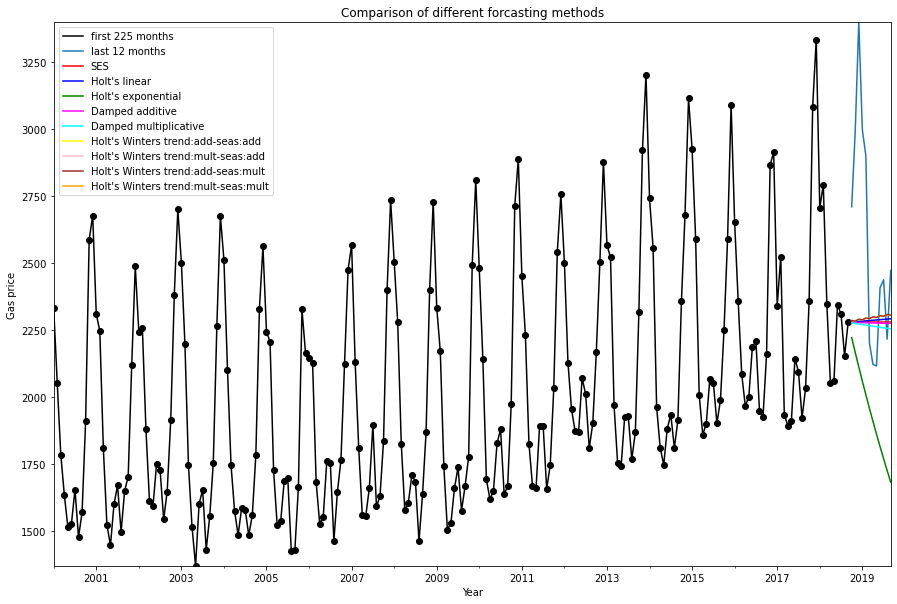

In [48]:


ax = usgas_first.plot(
    figsize=(15, 10),
    marker="o",
    color="black",
    title="Comparison of different forcasting methods",
)
ax.set_ylabel("Gas price")
ax.set_xlabel("Year")
usgas_last.plot(ax=ax, legend=True)
# forecast
time = 12
fcast1 = fit1.forecast(time).rename("SES")
fcast2 = fit2.forecast(time).rename("Holt's linear")
fcast3 = fit3.forecast(time).rename("Holt's exponential")
fcast4 = fit4.forecast(time).rename("Damped additive")
fcast5 = fit5.forecast(time).rename("Damped multiplicative")

# seasonal
fcast6 = fit_add_add.forecast(time).rename("Holt's Winters trend:add-seas:add")
fcast7 = fit_mult_add.forecast(time).rename("Holt's Winters trend:mult-seas:add")
fcast8 = fit_add_mult.forecast(time).rename("Holt's Winters trend:add-seas:mult")
fcast9 = fit_mult_mult.forecast(time).rename("Holt's Winters trend:mult-seas:mult")
fcast1 = pd.Series(fcast1)
fcast2 = pd.Series(fcast2)
fcast3 = pd.Series(fcast3)
fcast4 = pd.Series(fcast4)
fcast5 = pd.Series(fcast5)
fcast6 = pd.Series(fcast6)
fcast7 = pd.Series(fcast7)
fcast8 = pd.Series(fcast8)
fcast9 = pd.Series(fcast9)

colors = ['red', 'blue', 'green', 'magenta', 'cyan', 'yellow', 'pink', 'brown', 'orange']
fcast1.plot( ax=ax, color=colors[0], legend = True)
fcast2.plot( ax=ax, color=colors[1], legend = True)
fcast3.plot( ax=ax, color=colors[2], legend = True)
fcast4.plot( ax=ax, color=colors[3], legend = True)
fcast5.plot( ax=ax, color=colors[4], legend = True)
fcast6.plot( ax=ax, color=colors[5], legend = True)
fcast7.plot( ax=ax, color=colors[6], legend = True)
fcast8.plot( ax=ax, color=colors[7], legend = True)
fcast9.plot( ax=ax, color=colors[8], legend = True)

ax.set_ylim(np.min(usgas.to_numpy()), np.max(usgas.to_numpy()))

plt.show()
#usgas_last.plot(ax=ax, legend=True)
